# 10. Morphological operations

After the thresholding operation, one has a binary mask which is usually imperfect: object might have rough boundaries, holes etc.

Morphological operations are very commonly used to correct such masks. We focus here in particular on binary operations, i.e. operations acting on black and white images.

Let's import packages and quickly recreate a mask to work on. **Notice that we have to specifically import the morphology module from skimage which is not included by default**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.morphology

In [2]:
#image_stack = skimage.io.imread('../Data/myoblast.tif')
image_stack = skimage.io.imread('https://cildata.crbs.ucsd.edu/media/images/13585/13585.tif')
image_nuclei = image_stack[:,:,2]
my_otsu_threshold = skimage.filters.threshold_otsu(image_nuclei)
mask_otsu = image_nuclei > my_otsu_threshold

And let's focus on a smaller region:

In [3]:
cropped_mask = mask_otsu[200:300,100:200].copy()
cropped_image = image_nuclei[200:300,100:200].copy()

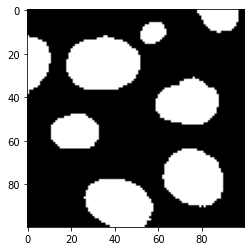

In [5]:
plt.imshow(cropped_mask, cmap = 'gray');

## 10.3 Erosion

In [6]:
help(skimage.morphology.binary_erosion)

Help on function binary_erosion in module skimage.morphology.binary:

binary_erosion(image, selem=None, out=None)
    Return fast binary morphological erosion of an image.
    
    This function returns the same result as greyscale erosion but performs
    faster for binary images.
    
    Morphological erosion sets a pixel at ``(i,j)`` to the minimum over all
    pixels in the neighborhood centered at ``(i,j)``. Erosion shrinks bright
    regions and enlarges dark regions.
    
    Parameters
    ----------
    image : ndarray
        Binary input image.
    selem : ndarray, optional
        The neighborhood expressed as a 2-D array of 1's and 0's.
        If None, use a cross-shaped structuring element (connectivity=1).
    out : ndarray of bool, optional
        The array to store the result of the morphology. If None is
        passed, a new array will be allocated.
    
    Returns
    -------
    eroded : ndarray of bool or uint
        The result of the morphological erosion ta

Erosion does what one expects: it shrinks the white regions. But how does it work ? Each pixel is visited. If it is white, one asks if any pixel in the neighborhood is black. If yes that pixel turns black. Of course this will only happen to pixels on the edges, as pixels in the middle of the nuclei are surrounded by white pixels.

We mentioned that the neighborhood is checked. The size of this neighborhood can be set by the user. For example we can observe a circular region around each pixel. The way to specify this neighborhood is give an image of it. Luckily, skimage has already implemented for us various shapes. For example a disk:

In [7]:
help(skimage.morphology.disk)

Help on function disk in module skimage.morphology.selem:

disk(radius, dtype=<class 'numpy.uint8'>)
    Generates a flat, disk-shaped structuring element.
    
    A pixel is within the neighborhood if the Euclidean distance between
    it and the origin is no greater than radius.
    
    Parameters
    ----------
    radius : int
        The radius of the disk-shaped structuring element.
    
    Other Parameters
    ----------------
    dtype : data-type
        The data type of the structuring element.
    
    Returns
    -------
    selem : ndarray
        The structuring element where elements of the neighborhood
        are 1 and 0 otherwise.



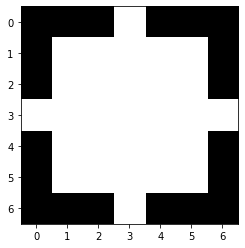

In [8]:
my_disk = skimage.morphology.disk(3)

plt.imshow(my_disk,cmap = 'gray');

Let's try to use this disk to erode our image:

In [9]:
my_eroded = skimage.morphology.erosion(cropped_mask, selem=my_disk)

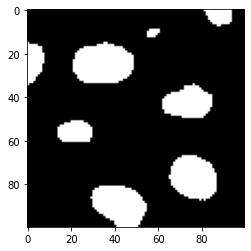

In [10]:
plt.imshow(my_eroded, cmap = 'gray');

To see what happened we can subtract the original and the eroded images:

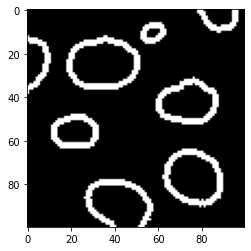

In [11]:
plt.imshow(cropped_mask.astype(int) - my_eroded.astype(int), cmap = 'gray');

What happends if we take an even larger neighborhood? 

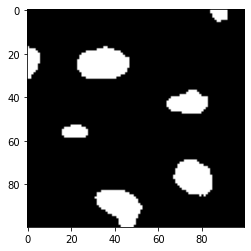

In [12]:
my_disk = skimage.morphology.disk(5)
my_eroded = skimage.morphology.erosion(cropped_mask, selem=my_disk)
plt.imshow(my_eroded, cmap = 'gray');

We lost one of the nuclei, which was so small that none of its pixels was "far enough" from a black pixel.

## 10.4 Dilation

Logically, dilation does the opposite of erosion: it visits every black pixel and verifies whether it has any white pixel in its neighborhood, and if yes turns it into white. Let's see an example:

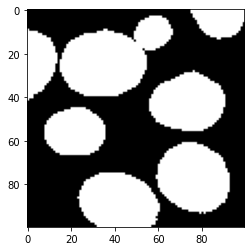

In [13]:
my_disk = skimage.morphology.disk(3)
my_dilation = skimage.morphology.dilation(cropped_mask, selem=my_disk)
plt.imshow(my_dilation, cmap = 'gray');

## 10.5 Combining operations

An efficient way to "clean-up" an image is to apply a series of such operations. Let's imagine that we for example want to remove very small nuclei. We can successively erode and dilate the image to remove object smaller than some threshold:

In [14]:
#1. Create neighborhood region
my_disk = skimage.morphology.disk(5)

#2. Erode the image to suppress small elements
my_cleanimage = skimage.morphology.erosion(cropped_mask, selem=my_disk)

#3. Dilate the eroded image to recover objects of the right size
my_cleanimage = skimage.morphology.dilation(my_cleanimage, selem=my_disk)

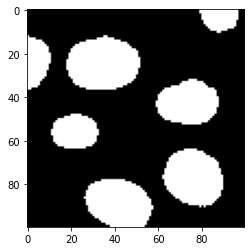

In [15]:
plt.imshow(my_cleanimage, cmap = 'gray');

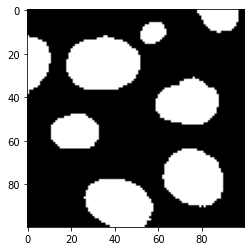

In [16]:
plt.imshow(cropped_mask, cmap = 'gray');

This combination of operations is very common and is called **binary opening**. It is so common that it is even implemented as a function of its own ```skimage.morphology.binary_opening```.